In [18]:
import os
import math
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [19]:
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

/tmp/ipykernel_4623/291196865.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [50]:
## Imports for plotting


In [6]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/t6"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Seed set to 42


Device: cuda:0


In [52]:
# import urllib.request
# from urllib.error import HTTPError
# # Github URL where saved models are stored for this tutorial
# base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# # Files to download
# pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# # Create checkpoint path if it doesn't exist yet
# os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# # For each file, check whether it already exists. If not, try downloading it.
# for file_name in pretrained_files:
#     file_path = os.path.join(CHECKPOINT_PATH, file_name)
#     if "/" in file_name:
#         os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
#     if not os.path.isfile(file_path):
#         file_url = base_url + file_name
#         print(f"Downloading {file_url}...")
#         try:
#             urllib.request.urlretrieve(file_url, file_path)
#         except HTTPError as e:
#             print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [53]:
from icecream import ic

In [54]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.shape[-1]
    attn_logits = torch.matmul(q, k.transpose(-2,-1))
    attn_logits = attn_logits/math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask==0, -9e15)
    # ic(attn_logits)
    attention = F.softmax(attn_logits, dim=-1)
    # ic(attention.shape, attention)
    # ic(v.shape, v)
    values = torch.matmul(attention, v)
    return values, attention 

In [55]:
seq_len, d_k = 3,2
pl.seed_everything(42)
q = torch.randint(1,5, size=(seq_len, d_k)).float()
k = torch.randint(1,5, size=(seq_len, d_k)).float()
v = torch.randint(1,5, size=(seq_len, d_k)).float()
# q, k, v
# q.shape
# kt = k.transpose(-2,-1)
# k, k.shape, kt, kt.shape
values, attention = scaled_dot_product(q,k,v)
q, k, v, values, attention

Seed set to 42


(tensor([[3., 4.],
         [1., 3.],
         [3., 4.]]),
 tensor([[1., 1.],
         [3., 2.],
         [3., 3.]]),
 tensor([[3., 3.],
         [4., 1.],
         [4., 4.]]),
 tensor([[4.0000, 3.8325],
         [3.9969, 3.6768],
         [4.0000, 3.8325]]),
 tensor([[4.7396e-05, 5.5805e-02, 9.4415e-01],
         [3.1098e-03, 1.0671e-01, 8.9018e-01],
         [4.7396e-05, 5.5805e-02, 9.4415e-01]]))

In [56]:
def expand_mask(mask:torch):
    assert mask.ndim >=2, 'Mask must be at least 2-dimensional'
    if mask.ndim==3:
        mask = mask.unsqueeze(1)
    while mask.ndim <4:
        mask = mask.unsqueeze(0)
    return mask

In [57]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim%num_heads ==0, 'Embedding dimensions must be 0 modulo number of heads'
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim//num_heads

        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)  
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()
    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0,2,1,3)
        q, k, v = qkv.chunk(3, dim=-1)

        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0,2,1,3)
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

        

In [58]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        super().__init__()

        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        self.linear_net = nn.Sequential(nn.Linear(input_dim, dim_feedforward),
                                        nn.Dropout(dropout),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(dim_feedforward, input_dim))
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out = self.self_attn(x, mask=mask)
        x = x+ self.dropout(attn_out)
        x = self.norm1(x)

        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x 
    

In [59]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args) -> None:
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) \
                                     for _ in range(num_layers)])
        
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x 
    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = layer(x)
        return attention_maps
            


In [60]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000) -> None:
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        ic(position.shape)
        ic(div_term.shape)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        ic(pe.shape)
        ic(div_term.shape)
        pe = pe.unsqueeze(0)
        ic(pe.shape)
        self.register_buffer('pe', pe, persistent=False)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [61]:
PositionalEncoding(20, 5)

PositionalEncoding()

In [62]:
ic.disable()

In [63]:
import numpy as np

In [64]:
class CosineWarmupSchedular(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)
    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        # ic(lr_factor)
        return [base_lr * lr_factor for base_lr in self.base_lrs]
    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

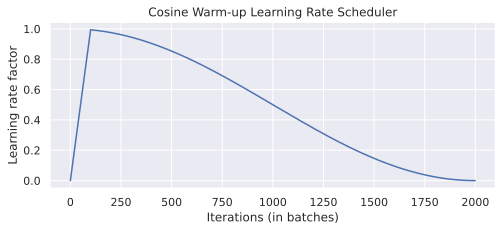

In [65]:
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupSchedular(optimizer=optimizer, warmup=100, max_iters=2000)
# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
# plt.plot(epochs, [lr_scheduler.get_lr(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [66]:
import wandb

In [67]:
wandb.init(project="test-lr_rate", entity="anashr")
p = nn.Parameter(torch.empty(4, 4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupSchedular(optimizer=optimizer, warmup=100, max_iters=2000)

# Example of logging learning rate factors for each iteration
for iteration in range(2000):
    # Update the learning rate using your scheduler here
    # This part depends on your training loop and how you've implemented lr updates
    
    # Get the current learning rate factor
    lr_factor = lr_scheduler.get_lr_factor(iteration)
    
    # Log the learning rate factor to wandb
    wandb.log({"Learning Rate Factor": lr_factor}, step=iteration)
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Learning Rate Factor,▂▅█████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Learning Rate Factor,0.0


In [68]:
class TransformerPredictor(pl.LightningModule):
    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0) -> None:
        super().__init__()
        self.save_hyperparameters()
        self._create_model()
    
    def _create_model(self):
        self.input_net = nn.Sequential(nn.Dropout(self.hparams.input_dropout),
                                    nn.Linear(self.hparams.input_dim, self.hparams.model_dim))
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              dropout=self.hparams.dropout)
        self.output_net = nn.Sequential(nn.Linear(self.hparams.model_dim,self.hparams.model_dim),
                                        nn.LayerNorm(self.hparams.model_dim),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(self.hparams.dropout),
                                        nn.Linear(self.hparams.model_dim,self.hparams.num_classes))
    def forward(self, x, mask=None, add_positional_encoding=True):
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x,mask=mask)
        return attention_maps
    # configure_optimizers
    def configure_optimizers(self):
        optimizer= optim.Adam(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = CosineWarmupSchedular(optimizer=optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler':lr_scheduler, 'interval':'step'}]
    def training_step(self, batch, batch_idx):
        raise NotImplementedError
    def validation_step(self, batch, batch_idx):
        raise NotImplementedError
    def test_step(self, batch, batch_idx):
        raise NotImplementedError
    # def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):

In [69]:
import torch.utils.data as data
class ReverseDataset(data.Dataset):
    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len=seq_len
        self.size=size
        self.data= torch.randint(self.num_categories, size=(self.size, self.seq_len))
    def __len__(self):
        return self.size
    def __getitem__(self,idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [70]:
rd = ReverseDataset(10,16,20)


In [71]:
i, la = rd[1]
ic(i.shape, la.shape)

(torch.Size([16]), torch.Size([16]))

In [72]:
# x = torch.arange(8).view(2, 2, 2)
# x

# torch.flip(x, [1,2])


In [73]:
from functools import partial
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(dataset(1000), batch_size=128, shuffle=True, drop_last=True)
test_loader = data.DataLoader(dataset(10000), batch_size=128, shuffle=True, drop_last=True)

In [74]:
db = next(iter(train_loader))

In [75]:
a, b = db
a.shape, b.shape

(torch.Size([128, 16]), torch.Size([128, 16]))

In [76]:
train_loader.dataset.num_categories

10

In [77]:
class ReversePredictor(TransformerPredictor):
    def _calculate_loss(self, batch, mode='train'):
        inp_data, labels = batch
        ic(inp_data.shape, labels.shape)
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()
        ic(inp_data.shape, labels.shape)
        preds = self.forward(inp_data, add_positional_encoding=True)
        ic(preds.shape, labels.shape)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        wandb.log({f'{mode}_loss': loss, f'{mode}_acc':acc})

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode='train')
        return loss
    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode='val')
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode='test')

In [78]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping

In [79]:
def train_reverse(**kwargs):
    root_dir = os.path.join(CHECKPOINT_PATH, 'ReverseTask')
    os.makedirs(root_dir, exist_ok=True)
    wandb_logger = WandbLogger(name="ReverseTask_new", project='Project_ReverseTask')
    early_stop_callback = EarlyStopping(
        monitor='val_acc',    # Metric to monitor
        min_delta=0.00,       # Minimum change to qualify as an improvement
        patience=3,           # Number of epochs with no improvement after which training will be stopped
        verbose=True,
        mode='max'            # Maximize the monitored metric
    )
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max',
                                                    monitor='val_acc'), early_stop_callback],
                                                    logger=wandb_logger,
                                                    accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                                                    devices=1,
                                                    max_epochs=10,
                                                    gradient_clip_val=5)
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'ReverseTask.ckpt')
    if os.path.isfile(pretrained_filename):
        print('Foound pretrained model, loading...')
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader),
                                 **kwargs)
        trainer.fit(model, train_loader, val_loader)
    
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(
        model, test_loader, verbose=False)
    
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    # Log final test and validation accuracy to wandb
    wandb_logger.log_metrics(result)

    model = model.to(device)
    wandb.finish()
    return model, result

In [80]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 352   
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 8.5 K 
3 | output_net          | Sequential         | 1.4 K 
-----------------------------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params
0.041     Total estimated model params size (MB)


/home/ubuntu/miniconda3/envs/lrenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/ubuntu/miniconda3/envs/lrenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/ubuntu/miniconda3/envs/lrenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 390/390 [00:03<00:00, 100.76it/s, v_num=8229]

Metric val_acc improved. New best score: 0.788


Epoch 1: 100%|██████████| 390/390 [00:03<00:00, 100.02it/s, v_num=8229]

Metric val_acc improved by 0.211 >= min_delta = 0.0. New best score: 0.999


Epoch 2: 100%|██████████| 390/390 [00:03<00:00, 99.73it/s, v_num=8229] 

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 1.000


Epoch 5: 100%|██████████| 390/390 [00:03<00:00, 99.42it/s, v_num=8229] 

Monitored metric val_acc did not improve in the last 3 records. Best score: 1.000. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 390/390 [00:03<00:00, 99.35it/s, v_num=8229]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/ubuntu/miniconda3/envs/lrenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/ubuntu/miniconda3/envs/lrenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 199.42it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 78/78 [00:00<00:00, 219.73it/s]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁▂▄▅▄▃▇▄▅▄▇▄▂▆▃▃▃█▃▄▄▂▄▄▄▃▃▅▆▁▅▄▃▇▅▃▄▃▇▄
train_acc,▁▁▁▂▃▄▆▇▇███████████████████████████████
train_loss,████▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▁▆▆▆▆▆▆████████████████████████████████
val_loss,██▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,6
test_acc,1.0
test_loss,0.00256


In [81]:
wandb.finish()

In [82]:
reverse_result

{'test_acc': 1.0, 'val_acc': 1.0}

In [83]:
# wandb.init(project="test-lr_rate", entity="anashr")
# wandb.log({"Learning Rate Factor": lr_factor}, step=iteration)
# wandb.finish()

In [31]:
from torchvision import transforms
from torchvision.datasets import CIFAR100
import torchvision
import numpy as np
from torch.utils import data as data

In [20]:
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS,DATA_STD)])
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [21]:
os.environ['TORCH_HOME'] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
pretrained_model = pretrained_model.to(device)

pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [22]:
from icecream import ic

In [23]:
from tqdm import tqdm
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=True, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats =  pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, 'train_set_features.tar')
train_set_feats = extract_features(train_set, train_feat_file)
test_feat_file = os.path.join(CHECKPOINT_PATH, 'test_set_features.tar')
test_set_feats = extract_features(test_set, test_feat_file)

In [24]:
ic(train_set_feats.shape, test_set_feats.shape)

ic| train_set_feats.shape: torch.Size([50000, 512])
    test_set_feats.shape: torch.Size([10000, 512])


(torch.Size([50000, 512]), torch.Size([10000, 512]))

In [25]:
import torch

# Simulated labels for a dataset with an imbalanced number of images per class
labels = torch.tensor([0, 1, 2, 0, 1, 2, 0, 2, 0])  # Example labels
num_labels = labels.max() + 1

# Sorting indices of images by their class labels
sorted_indices = torch.argsort(labels)

# Instead of reshaping, use a list to collect indices for each class
indices_per_class = [sorted_indices[labels[sorted_indices] == i] for i in range(num_labels)]

# Now, indices_per_class is a list of tensors, each tensor containing indices of images for a class
indices_per_class

[tensor([0, 3, 6, 8]), tensor([1, 4]), tensor([2, 5, 7])]

In [36]:
labels = train_set.targets
labels = torch.LongTensor(labels)

num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels,-1)
val_exmps = sorted_indices.shape[1] // 10
val_indices = sorted_indices[:,:val_exmps].reshape(-1)
train_indices = sorted_indices[:,val_exmps:].reshape(-1)

train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats, val_labels = train_set_feats[val_indices], labels[val_indices]

In [147]:
class SetAnomalyDataset(data.Dataset):
    def __init__(self, img_feats, labels, set_size=10, train=True) -> None:
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size
        self.train = train

        # tensors with indices of images per class
        ic(labels.shape)
        self.num_labels = labels.max()+1
        ic(self.num_labels)
        self.img_idx_by_label = torch.argsort(labels).reshape(self.num_labels, -1)

        if not self.train:
            self.test_sets = self._create_test_sets()
    def _create_test_sets(self):
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        ic(test_sets.shape)
    
    def sample_img_set(self, anomaly_label):
        # set_label = np.random.randint(self.num_labels-1)
        set_label = 99
        if set_label >= anomaly_label:
            set_label+=1
        ic(set_label, anomaly_label)
        ic(self.img_idx_by_label.shape)
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices
    def __len__(self):
        return self.img_feats.shape[0]
    def __getitem__(self, idx):
        ic(self.img_feats.shape)
        anomaly = self.img_feats[idx]
        ic(anomaly.shape, self.train)
        if self.train:
            ic(idx)
            ic(self.labels.shape, self.labels[idx])
            img_indices = self.sample_img_set(self.labels[idx])
            ic(img_indices.shape)
        else:
            img_indices = self.test_sets[idx]
        ic(self.img_feats[img_indices].shape, anomaly.shape)
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        ic(img_set.shape)
        indices = torch.cat([img_indices, torch.LongTensor([idx])],dim=0)
        ic(indices.shape)
        
        

In [148]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)

ic| labels.shape: torch.Size([45000])
ic| self.num_labels: tensor(100)


In [149]:
train_anom_dataset.sample_img_set(train_labels[0])

ic| set_label: 100, anomaly_label: tensor(0)
ic| self.img_idx_by_label.shape: torch.Size([100, 450])


IndexError: index 100 is out of bounds for dimension 0 with size 100

In [150]:

train_anom_dataset[0]

ic| self.img_feats.shape: torch.Size([45000, 512])
ic| anomaly.shape: torch.Size([512]), self.train: True
ic| idx: 0
ic| self.labels.shape: torch.Size([45000])
    self.labels[idx]: tensor(0)
ic| set_label: 100, anomaly_label: tensor(0)
ic| self.img_idx_by_label.shape: torch.Size([100, 450])


IndexError: index 100 is out of bounds for dimension 0 with size 100